In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean
import seaborn as sns
import xarray as xr
import pyproj
import geopandas as gpd
import subprocess
import matplotlib.path as mpath
import os
import shutil

from tqdm.notebook import tqdm
from osgeo import gdal

# Maximum Entropy Species Distribution Modeling
- Using MaxEnt model with B-SOSE Southern Ocean State Estimate and SOPHY phytoplankton presence data to build seasonal species distribution models

In [10]:
def so_ax():
  """
  Create a map of the Southern Ocean.
  """
  map_proj = ccrs.SouthPolarStereo()
  fig = plt.figure(figsize=[12, 12])  # inches
  ax = plt.subplot(projection=map_proj)
  ax.set_extent([-180, 180, -90, -29.4], ccrs.PlateCarree())
  ax.gridlines(linestyle='--', draw_labels=True)
  ax.add_feature(cartopy.feature.LAND)
  return ax

# Make SO plot boundary a circle
def plot_circle_boundary(ax):
    """
    Make SO plot boundary a circle.
    Compute a circle in axes coordinates, which we can use as a boundary for the map.
    We can pan/zoom as much as we like - the boundary will be permanently circular.
    """
    theta  = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5  # could use 0.45 here, as Simon Thomas did
    verts  = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform = ax.transAxes)
    return ax

# TODO: replace xllcorner, yllcorner with calculated values instead of hardcoding
ncols = 2160
nrows = 588
xllcorner = -20028230.586156055
yllcorner = -14317550.37951785
cellsize = 18550
NODATA_value = -9999

def bsose_netcdf_to_asc(input: str, output: str):
  # Open the input dataset
  ds = gdal.Open(input)
  # Read the data as a Numpy array
  data = ds.ReadAsArray()
  # Convert all nans to the NODATA_value
  data[np.isnan(data)] = NODATA_value
  # Split the array into left and right halves
  left, right = np.hsplit(data, 2)
  # Swap the left and right halves
  data = np.hstack((right, left))
  # Create a memory driver and a memory dataset
  mem_driver = gdal.GetDriverByName('MEM')
  mem_ds = mem_driver.Create('', ds.RasterXSize, ds.RasterYSize, 1, gdal.GDT_Float32)
  # Write the flipped data to the memory dataset
  mem_ds.GetRasterBand(1).WriteArray(data)
  # Set the output options
  # outputBounds = [ulx, uly, lrx, lry]
  header = gdal.TranslateOptions(
      format='AAIGrid',
      outputSRS='EPSG:4326',
      outputBounds=[xllcorner, yllcorner + nrows * cellsize, xllcorner + ncols * cellsize, yllcorner],
      width=ncols,
      height=nrows,
      noData=NODATA_value
  )
  # Create the output dataset
  out_ds = gdal.Translate(output, mem_ds, options=header)
  # Close the datasets; flush the memory
  ds = None
  mem_ds = None
  out_ds = None

In [11]:
seasons = ['summer', 'autumn', 'winter', 'spring']
# austral summer (December–February), autumn (March–May), winter (June–August), and spring (September–November)
seasons_months: dict = {'summer': (12, 1, 2), 'autumn': (3, 4, 5), 'winter': (6, 7, 8), 'spring': (9, 10, 11)}
var_info = {'THETA': {'cmap': cmocean.cm.thermal, 'simple_name': 'temperature', 'file_prefix': 'Theta', 'vmin': -5},
            'SIarea': {'cmap': cmocean.cm.ice, 'simple_name': 'sea_ice_extent', 'file_prefix': 'SeaIceArea', 'vmin': 0},
            'SALT': {'cmap': cmocean.cm.haline, 'simple_name': 'salinity', 'file_prefix': 'Salt', 'vmin': 30},
            'TRAC03': {'cmap': cmocean.cm.oxy, 'simple_name': 'oxygen', 'file_prefix': 'O2', 'vmin': 0},
            'TRAC04': {'cmap': cmocean.cm.matter, 'simple_name': 'nitrate', 'file_prefix': 'NO3', 'vmin': 0},
            'BLGCHL': {'cmap': cmocean.cm.algae, 'simple_name': 'chlorophyll', 'file_prefix': 'Chl', 'vmin': 0}}

figures_dir = '../../figures'
bsose_raw_dir = '../../data/maxent/in/bsose_raw'
bsose_processed_nc_dir = '../../data/maxent/in/bsose_processed/netcdf'
bsose_processed_asc_dir = '../../data/maxent/in/bsose_processed/asc'
presence_raw_dir = '../../data/in/datasets/mod/phytobase.csv'
presence_processed_dir = '../../data/maxent/in/sophy_presence_processed'
maxent_app_file = "../../data/maxent/app/maxent.jar"
output_dir = '../../data/maxent/out/java'
fronts_shapefile = '../../data/out/shapefiles/fronts/so_fronts.shp'

## Raw B-SOSE data processing
- In: monthly averages for 5 year span (2013-2017) per environmental variable
- Out: 4 seasonal averages (autumn, winter, spring, summer) per environmental variable

In [20]:
YEARS = 6
MO_PER_YEAR = 12
MO_PER_SEASON = 3

# TODO: ADD CHECK TO NOT RUN IF PROCESSED DATA ALREADY EXISTS
# print('Processed data already exists. Skipping. If you want to reprocess, change the output directory and rerun.')

bsose_season_indices: dict = {}
for season in seasons_months.keys():
  # BSOSE has 6 years x 12 months = 72 months of data
  # This dict stores the indicies of the months in each season across the 6 years
  # Ex: 'summer' -> [11, 0, 1, 23, 12, 13, ...]
  bsose_season_indices[season] = (np.tile(np.arange(0, MO_PER_YEAR * YEARS, MO_PER_YEAR), (MO_PER_SEASON, 1)).T + (np.asarray(seasons_months.get(season)) - 1)).flatten()


for var in tqdm(var_info.keys(), desc='Processing BSOSE datasets'):
  for season in seasons:
    # Open the BSOSE dataset
    ds = xr.open_dataset(f"{bsose_raw_dir}/bsose_i133_2013to2018_monthly_{var_info.get(var)['file_prefix']}.nc")
    # Ex: ds[var] = <xarray.DataArray 'SALT' (time: 72, Z: 52, YC: 588, XC: 2160)>
    if var == 'SIarea':
      # SIarea is a 2D field, so no need to average over depth
      ds = ds[var][bsose_season_indices.get(season), :, :].mean(dim='time')
    else:
      # Average over time and depth
      top50m = np.arange(8) # indices [0, 7] is the top 50m in BSOSE
      ds = ds[var][bsose_season_indices.get(season), top50m, :, :].mean(dim=('time', 'Z'))
      ds = ds.where(ds > var_info.get(var)['vmin'])
    # ds.plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap=var_info.get(var)['cmap'])
    # ax.add_feature(cartopy.feature.LAND, zorder=2)
    ds.to_netcdf(f'{bsose_processed_nc_dir}/{var_info.get(var)["simple_name"]}_{season}.nc')

Processing BSOSE datasets:   0%|          | 0/6 [00:00<?, ?it/s]

## Plotting processed B-SOSE environmental layers

Processing environmental variables:   0%|          | 0/6 [00:00<?, ?it/s]

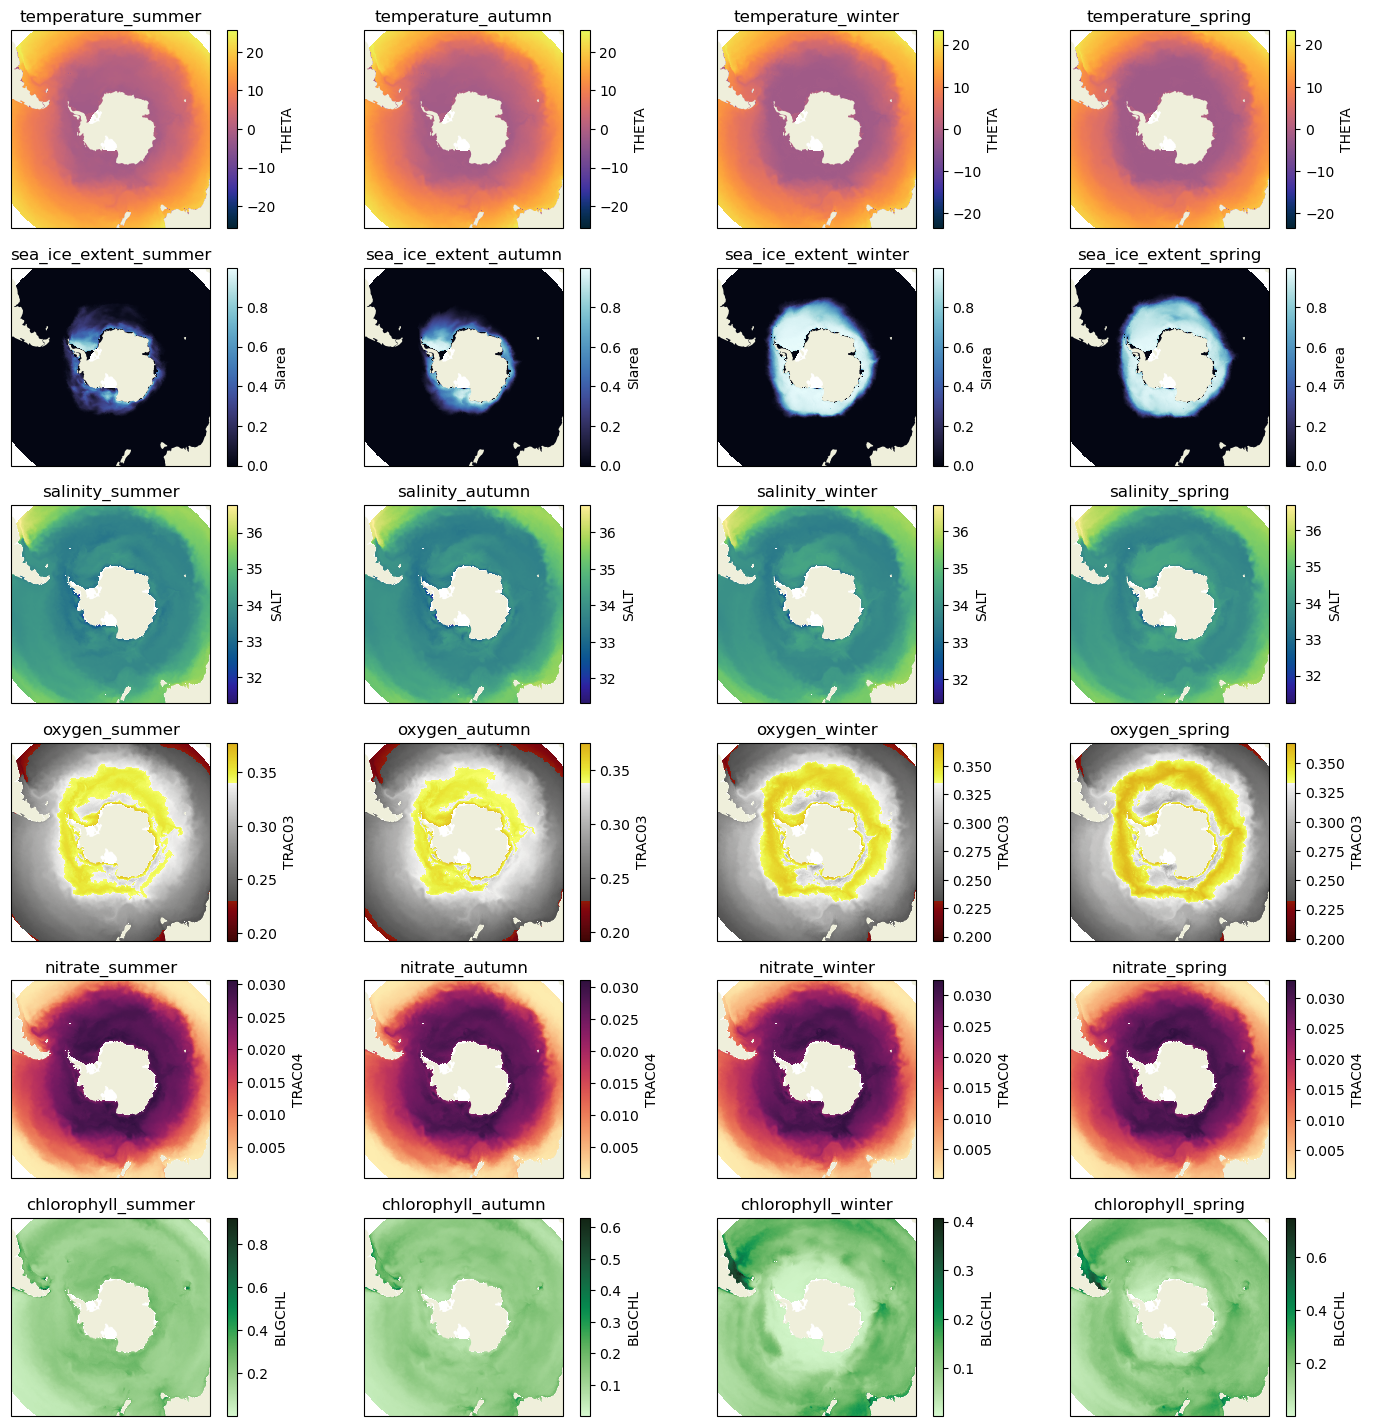

In [21]:
# TODO: make shared colorbar for each variable and season labels

# Open the newly processed datasets and plot them
# fig, axes = plt.subplots(len(var_info), len(seasons), figsize=(16, 16), subplot_kw={'projection': ccrs.SouthPolarStereo()})
mosaic = [[var_info.get(var)['simple_name'] + '_' + season for season in seasons] for var in var_info.keys()]
subplots_kwargs = dict(sharex=True, sharey=True, figsize=(18, 18), subplot_kw={'projection': ccrs.SouthPolarStereo()})
fig, axes = plt.subplot_mosaic(mosaic, **subplots_kwargs)

for var in tqdm(var_info.keys(), desc='Processing environmental variables'):
  for season in seasons:
    ax = axes[var_info.get(var)['simple_name'] + '_' + season]
    ax.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    ds = xr.open_dataset(f'{bsose_processed_nc_dir}/{var_info.get(var)["simple_name"]}_{season}.nc')
    ds[var].plot.pcolormesh(x="XC", y="YC", ax=ax, transform=ccrs.PlateCarree(), cmap=var_info.get(var)['cmap'])
    ax.set_title(var_info.get(var)['simple_name'] + '_' + season)
    ax.add_feature(cartopy.feature.LAND, zorder=2)
    bsose_netcdf_to_asc(input=f'{bsose_processed_nc_dir}/{var_info.get(var)["simple_name"]}_{season}.nc', output=f'{bsose_processed_asc_dir}/{season}/{var_info.get(var)["simple_name"]}_{season}.asc')
  # TODO: set variable wide colorbar based on min and max
  # plt.colorbar(ax=ax, orientation='vertical', pad=0.05, shrink=0.8, label=var_info.get(var)['simple_name'])
plt.subplots_adjust(wspace=0.05)
# plt.savefig(figures_dir + '/bsose_processed_mosaic.png')

## SOPHY data processing
- Filter out extra columns and split by season

In [22]:
presence = pd.read_csv(presence_raw_dir)
presence['timestamp'] = pd.to_datetime(presence['timestamp'], errors='coerce')
presence = presence.filter(['longitude', 'latitude', 'class', 'timestamp'])
# reorder the columns (required by MaxEnt)
presence = presence[['class', 'longitude', 'latitude', 'timestamp']]
# Get the top 5 classes by count
top5 = presence['class'].value_counts().head(5)
# Filter the presence dataset to only include the top 5 classes
presence = presence[presence['class'].isin(top5.index)]
presence['class'].value_counts()

Bacillariophyceae    20005
Dinophyceae           8007
Prymnesiophyceae      3913
Coccolithophyceae     2810
Cyanophyceae          1681
Name: class, dtype: int64

<GeoAxesSubplot: xlabel='longitude', ylabel='latitude'>

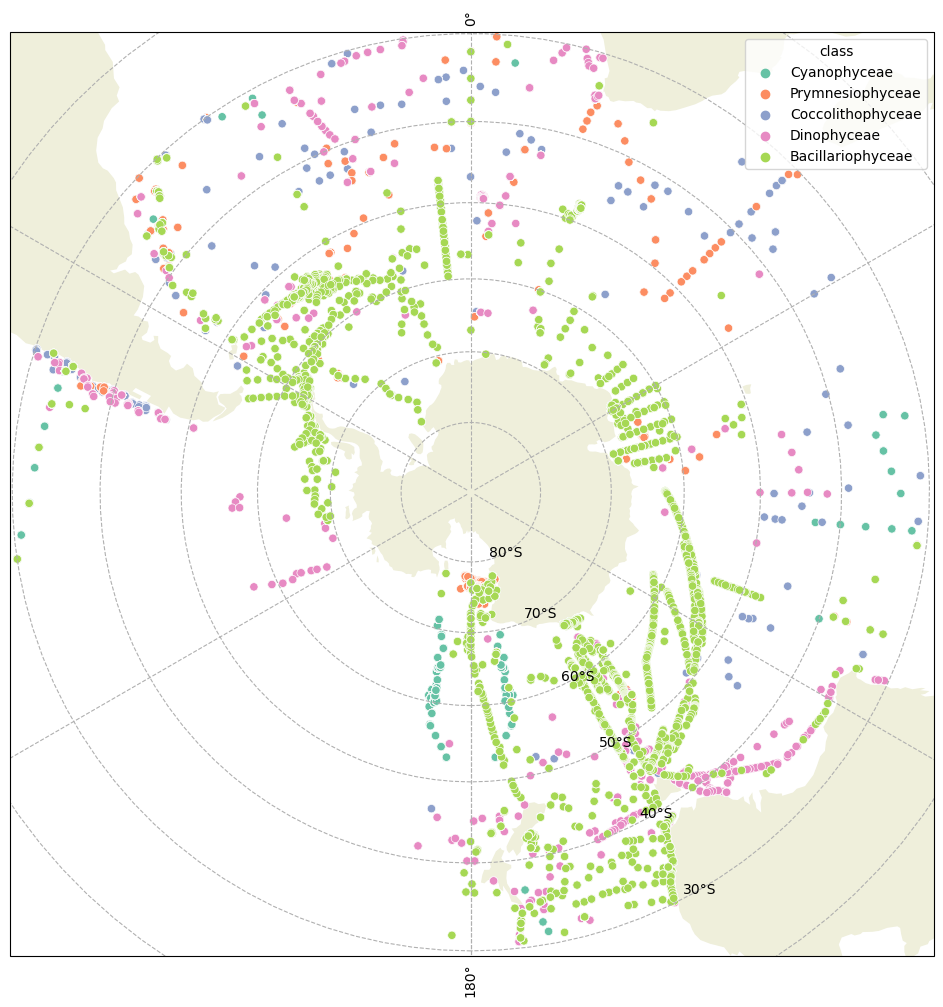

In [23]:
sns.scatterplot(x='longitude', y='latitude', hue='class', data=presence, palette='Set2', ax=so_ax(), transform=ccrs.PlateCarree())

In [24]:
# Project data into Mercator projection. This is the projection needed for the envinronmental layers to be an even grid of pixels.
# Mercator projection = EPSG:3395
proj = pyproj.Transformer.from_crs(4326, 3395, always_xy=True)
lon2, lat2 = proj.transform(presence['longitude'], presence['latitude'])
presence['longitude'] = lon2
presence['latitude'] = lat2
presence

class     longitude      latitude  timestamp
736         Cyanophyceae -8.696279e+06 -3.918364e+06 2004-12-04
737         Cyanophyceae -8.696279e+06 -3.918364e+06 2004-12-04
738         Cyanophyceae -8.696279e+06 -3.918364e+06 2004-12-04
739         Cyanophyceae -8.696279e+06 -3.918364e+06 2004-12-04
740         Cyanophyceae -8.696279e+06 -3.918364e+06 2004-12-04
...                  ...           ...           ...        ...
37189  Bacillariophyceae  1.669904e+07 -5.381168e+06 1984-02-14
37190  Bacillariophyceae  1.670271e+07 -7.695749e+06 1984-02-12
37191  Bacillariophyceae  1.677139e+07 -4.251558e+06 1984-02-16
37192  Bacillariophyceae  1.867384e+07 -4.966686e+06 1961-01-30
37193  Bacillariophyceae  5.218658e+05 -3.614623e+06 2010-09-14

[36416 rows x 4 columns]

In [25]:
# Split up the dataset by season
# seasons_months: dict = {'summer': (12, 1, 2), 'autumn': (3, 4, 5), 'winter': (6, 7, 8), 'spring': (9, 10, 11)}

for season in tqdm(seasons_months.keys(), desc='Splitting presence dataset by season'):
  presence_season = presence[presence['timestamp'].dt.month.isin(seasons_months.get(season))].drop(columns=['timestamp'])
  presence_season.to_csv(f'{presence_processed_dir}/sophy_mercator_{season}.csv', index=False)

Splitting presence dataset by season:   0%|          | 0/4 [00:00<?, ?it/s]

## Run the MaxEnt software through the command line
- In: processed B-SOSE environmental layers and SOPHY phytoplankton presence data
- Out: MaxEnt model output
- Call the MaxEnt Java executable through the command line
- NOTE: You will need the Java SDK and JRE installed to run MaxEnt. If you followed the miniconda installation instructions, you should already have Java installed. If not, you can download it here: https://www.oracle.com/java/technologies/javase-downloads.html

In [26]:
# NOTE: Notice how the installation is within the conda environment. This is important because the conda environment has all the dependencies needed to run this notebook.
# Deleting this conda environment will also remove the Java installation
if shutil.which("java"):
  print("Java installation found: \n" + shutil.which("java"))

Java installation found: 
c:\Users\Ayush Nag\miniconda3\envs\sophyvenv\Library\bin\java.EXE


In [27]:
max_bytes_ram = 2000
# NOTE: Threads is the number of cores to use. Set this to max available for greatly improved performance.
options: dict = {'threads': 4,
                  'randomtestpoints': 20,
                  'responsecurves': True,
                  'jackknife': True,
                  'redoifexists': True,
                  'autorun': True,
                  'warnings': False}
# Convert the options dict to a string of flags for command line use
flags = ''.join([f"{key}={value} " for key, value in options.items()])

for season in tqdm(seasons, desc='Running MaxEnt'):
  asc_season_dir = f"{bsose_processed_asc_dir}/{season}"
  samples_file = f"{presence_processed_dir}/sophy_mercator_{season}.csv"
  season_output = f"{output_dir}/{season}"
  maxent_command = f"java -mx{max_bytes_ram}m -jar {maxent_app_file} environmentallayers={asc_season_dir} samplesfile={samples_file} outputdirectory={season_output} {flags}"
  subprocess.run(maxent_command, shell=True)

Running MaxEnt:   0%|          | 0/4 [00:00<?, ?it/s]

## Plot the MaxEnt model results

In [28]:
# Create base grid in Mercator projection for environmental layers
# Picked random envinronmental layer to get the grid from
sal = xr.open_dataset(f'{bsose_processed_nc_dir}/salinity_summer.nc')
x, y = sal.XC.to_numpy(), sal.YC.to_numpy()
mx, my = np.meshgrid(x, y)
proj = pyproj.Transformer.from_crs(4326, 3395, always_xy=True)
mx, my = proj.transform(mx, my)

def plot_maxent_asc(filename: str, ax: plt.Axes) -> plt.Axes:
  ds = gdal.Open(filename)
  distribution_grid = ds.ReadAsArray()
  distribution_grid = np.flipud(distribution_grid)
  # Split the array into left and right halves
  left, right = np.hsplit(distribution_grid, 2)
  # Swap the left and right halves
  distribution_grid = np.hstack((right, left))
  # Mask the NODATA values
  distribution_grid = np.ma.masked_where(distribution_grid == NODATA_value, distribution_grid)
  ax.pcolormesh(mx, my, distribution_grid, transform=ccrs.Mercator(), cmap=cmocean.cm.thermal)
  return ax

Building species distribution plots:   0%|          | 0/5 [00:00<?, ?it/s]

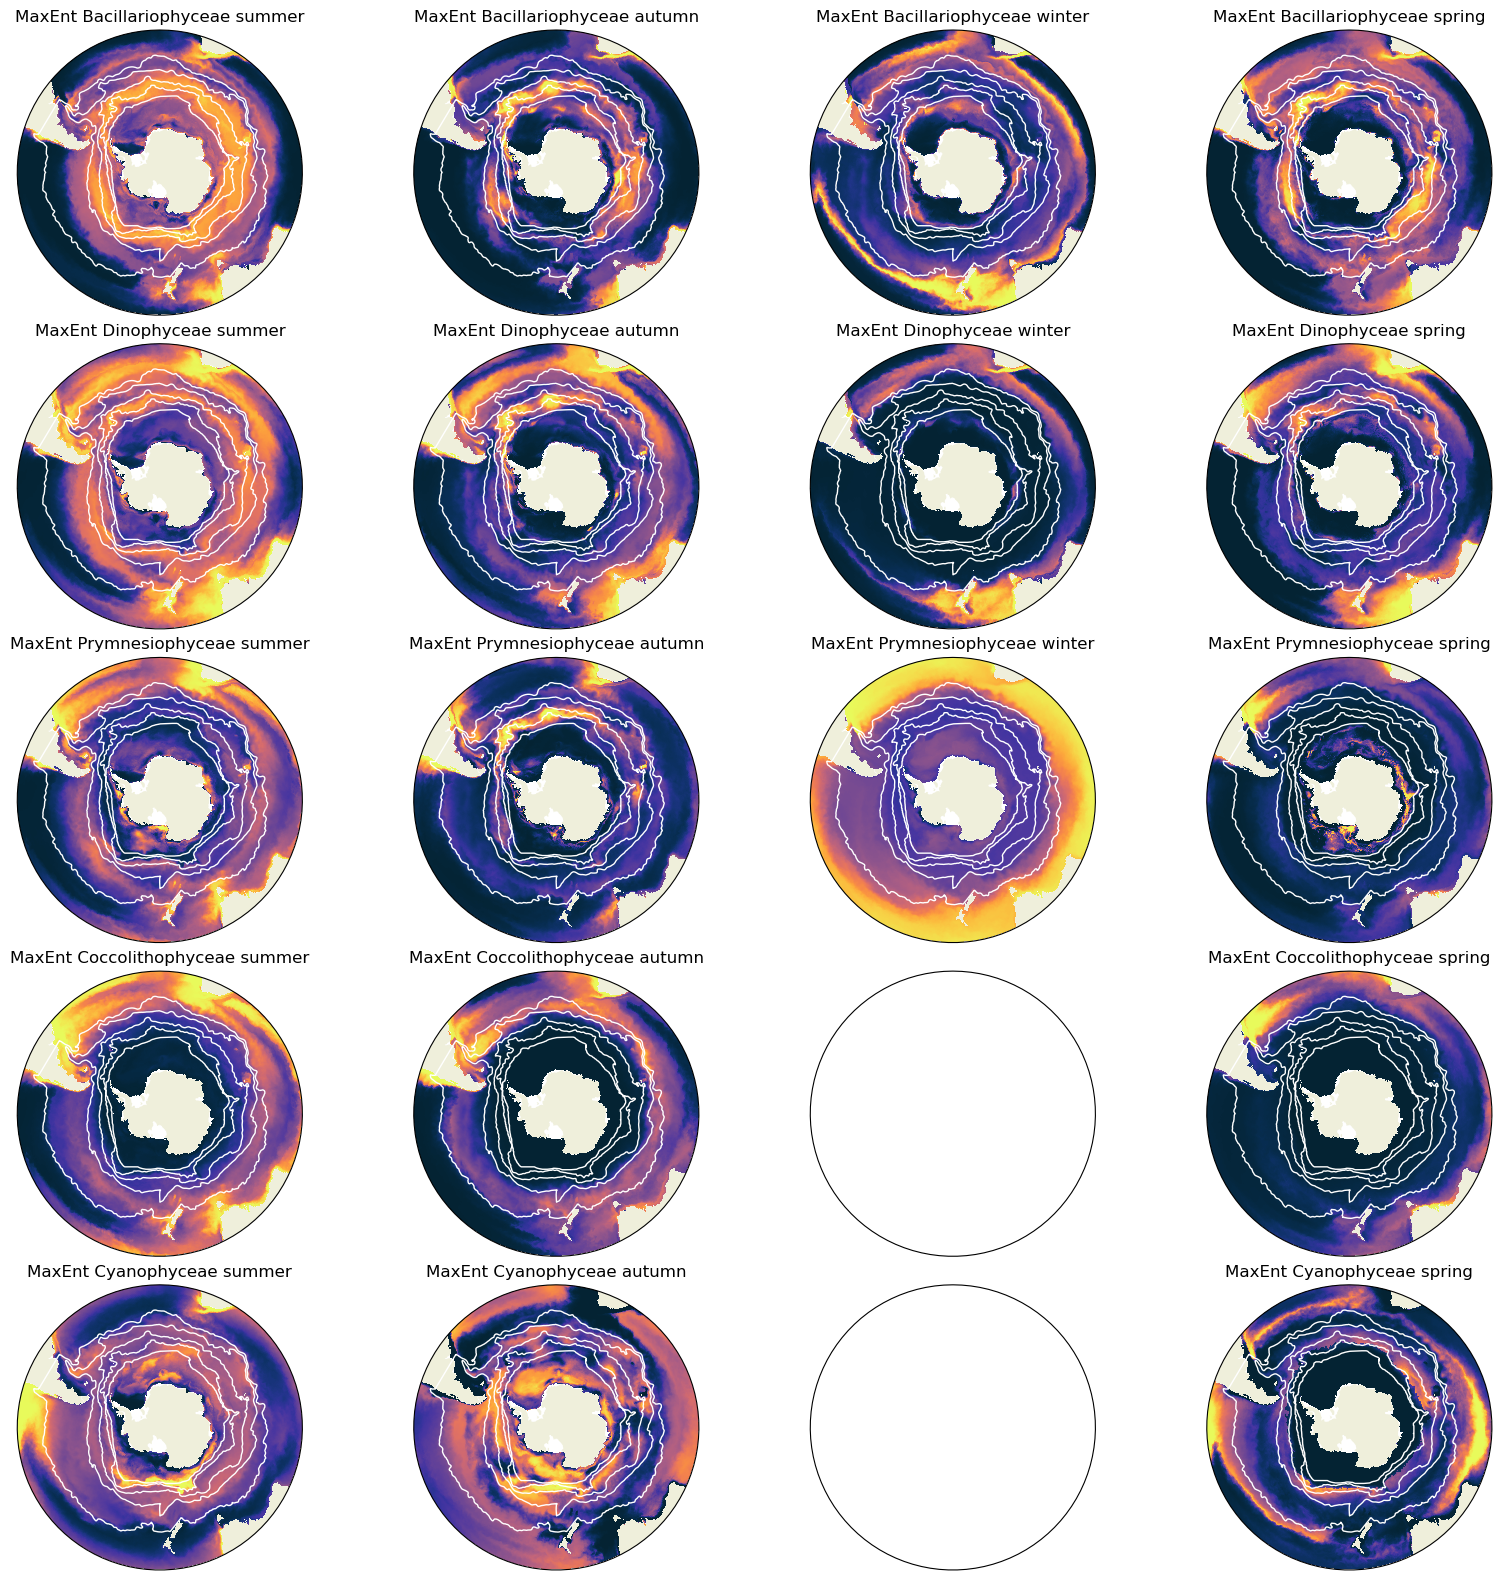

In [30]:
# Create a mosaic of plots for each species and season: format=[[bacillariophyceae_summer, bacillariophyceae_autumn, ...], ...]
mosaic = [[species + '_' + season for season in seasons] for species in top5.index]
subplots_kwargs = dict(sharex=True, sharey=True, figsize=(20, 20), subplot_kw={'projection': ccrs.SouthPolarStereo()})
fig, axes = plt.subplot_mosaic(mosaic, **subplots_kwargs)

fronts = gpd.read_file(fronts_shapefile)
for species in tqdm(top5.index, desc='Building species distribution plots'):
  for season in seasons:
    ax = axes[species + '_' + season]
    ax.set_extent([-180, 180, -90, -29.4], ccrs.PlateCarree())
    # ax = so_ax()
    ax = plot_circle_boundary(ax)
    # skip the file if non-existent
    if not os.path.isfile(f'{output_dir}/{season}/{species}.asc'): continue
    # plot the maxent distribution
    ax = plot_maxent_asc(f'{output_dir}/{season}/{species}.asc', ax)
    # add the southern ocean fronts simply for reference
    fronts.plot(ax=ax, color='none', edgecolor='white', linewidth=1, transform=ccrs.SouthPolarStereo())
    ax.add_feature(cartopy.feature.LAND)
    ax.set_title(f'MaxEnt {species} {season}')
plt.subplots_adjust(hspace=0.1, wspace=0.1)

Text(0.5, 1.0, 'MaxEnt Bacillariophyceae probability distribution')

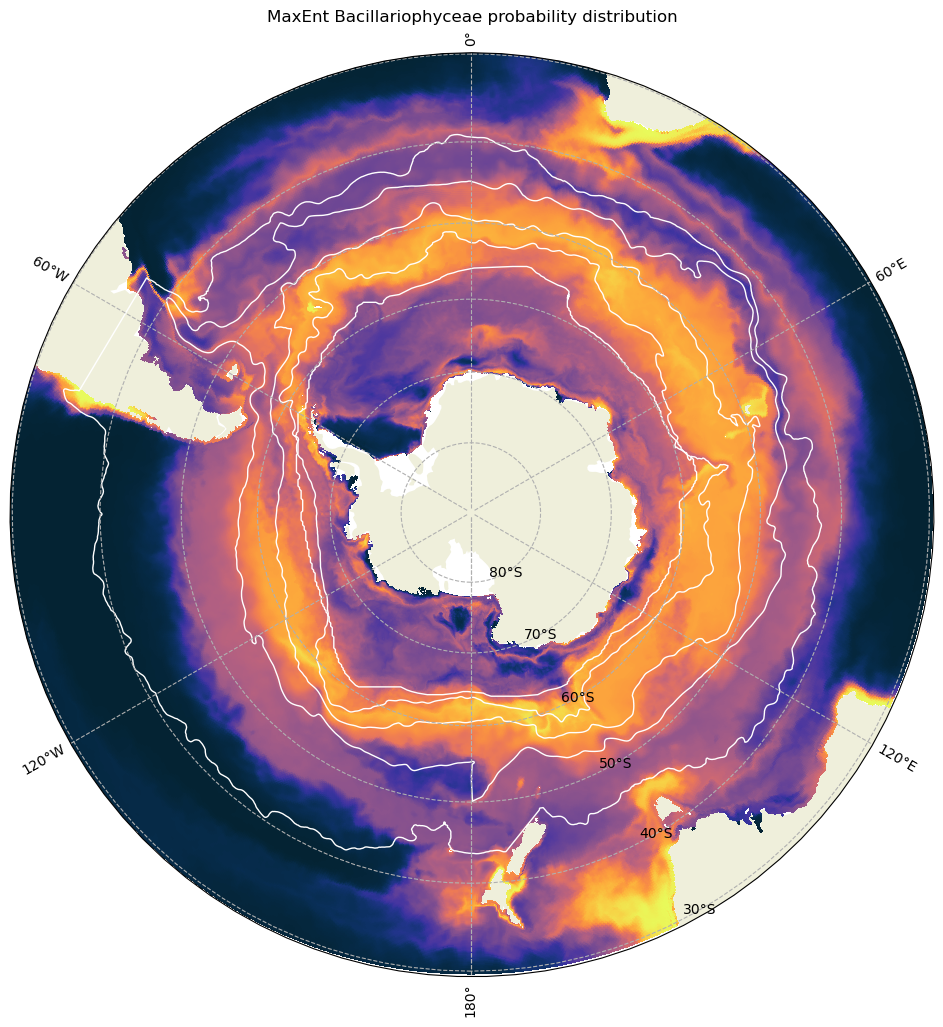

In [32]:
# species options = ['Bacillariophyceae', 'Coccolithophyceae', 'Cyanophyceae', 'Prymenesiophyceae', 'Dinophyceae']
species = "Bacillariophyceae"
season = "summer"
ax = so_ax()
ax = plot_circle_boundary(ax)
ax = plot_maxent_asc(f'{output_dir}/{season}/{species}.asc', ax)
gpd.read_file(fronts_shapefile).plot(ax=ax, color='none', edgecolor='white', linewidth=1, transform=ccrs.SouthPolarStereo())
ax.set_title(f"MaxEnt {species} probability distribution") 